## Brief tutorial on how to use the local routines

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from test_util import test_data as td

import dga.brillouin_zone as bz
import dga.two_point as tp

dmft_data, hr = td.load_minimal_dataset()

# Unpack parts of the dmft_data:
beta = dmft_data['beta']
totdens = dmft_data['n']
u = dmft_data['u']

# Define k-lattice:
symmetries = bz.two_dimensional_square_symmetries()
nk = (100,100,1)
k_grid = bz.KGrid(nk,symmetries)
ek = hr.get_ek(k_grid)

# Create the Green's function:
siw_obj = tp.SelfEnergy(dmft_data['siw'][None,None,None,:],beta)
giwk_obj = tp.GreensFunction(siw_obj,ek,n=totdens)

giw = giwk_obj.g_loc

In [2]:
dmft_data.keys()

dict_keys(['giw', 'siw', 'n', 'beta', 'u', 'mu_dmft', 'g4iw_dens', 'g4iw_magn', 'g4iw_sing', 'g4iw_trip'])

After initial setup let us create various four-point (two particle) object and look at them.
For this the 'lfp.LocalFourPoint' class is used, which stored additional information like the inverse thermal temperature
(beta), which spin-channel is considered (channel) and the matrix of the four-point function (matrix).

Aside from storing this additional information and some simple functionality, the class contains a plot function to visualize the
object.

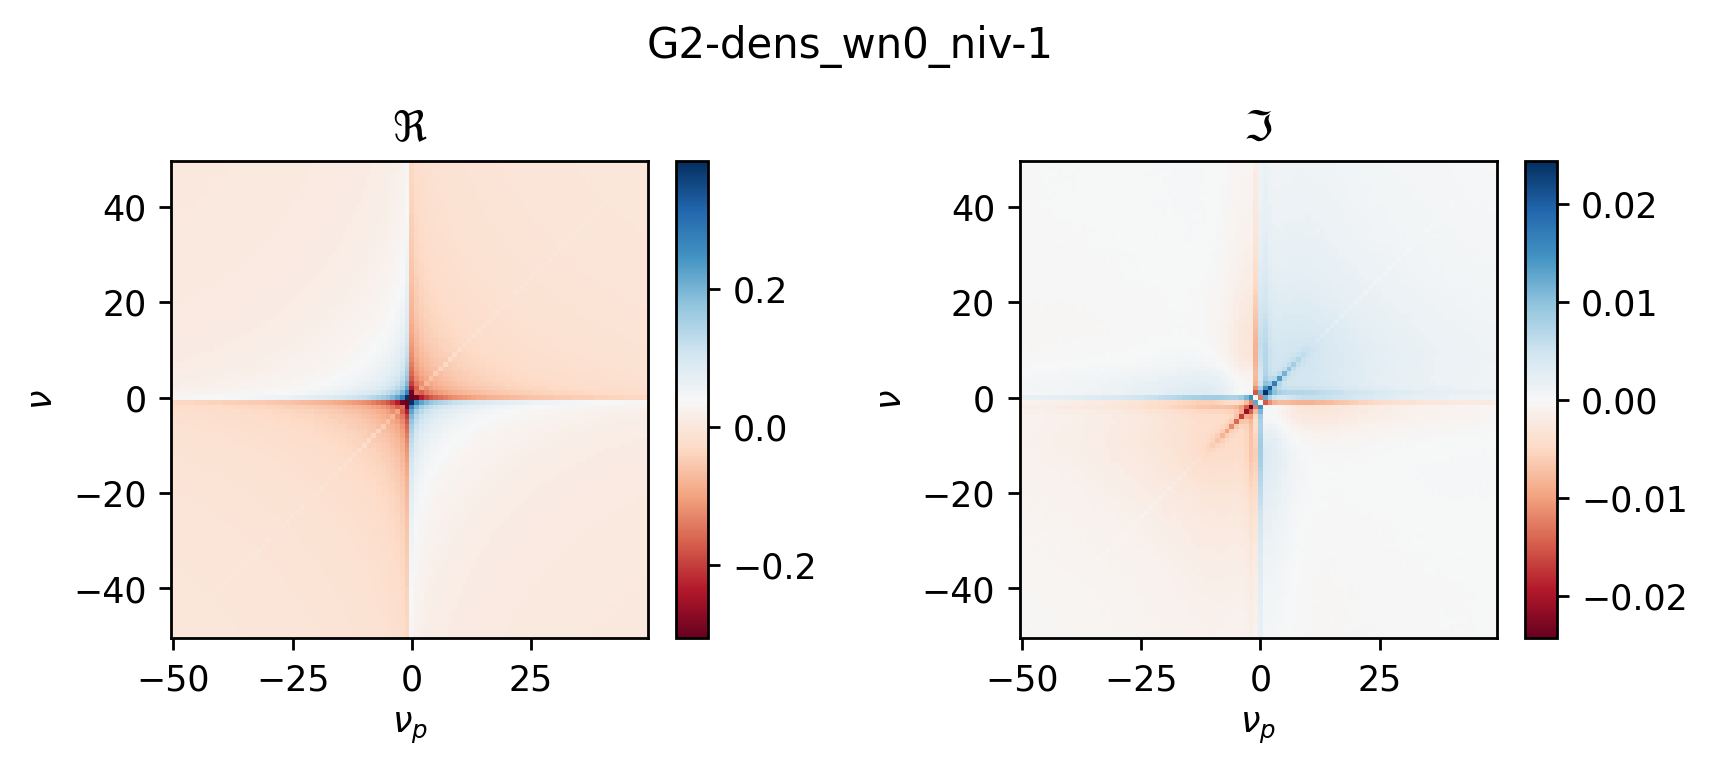

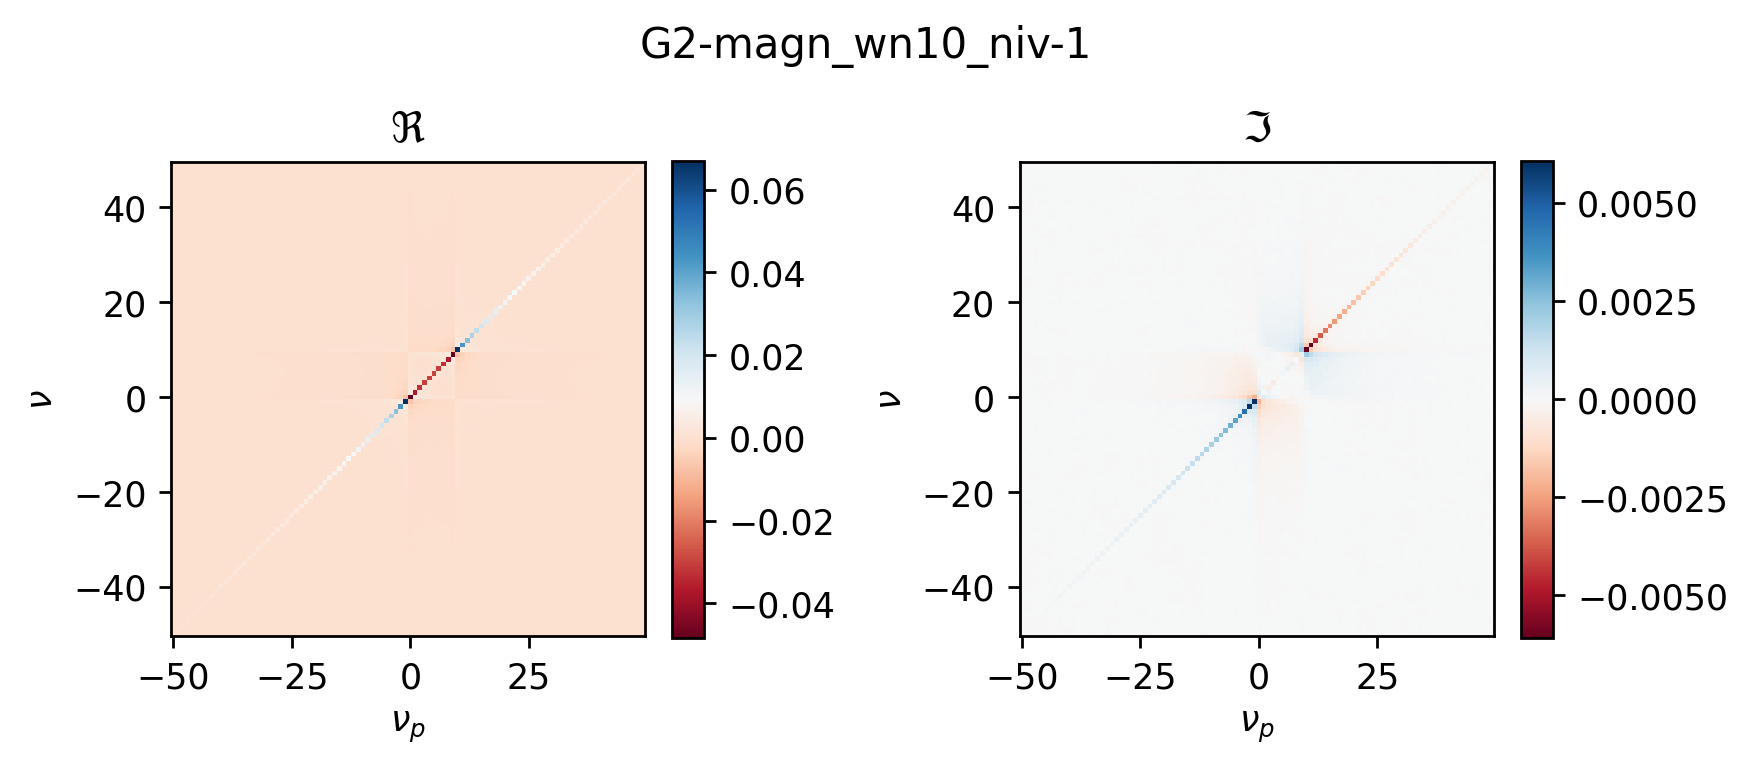

In [3]:
# Create the two-particle Green's function objects:
import dga.local_four_point as lfp
g4iw_dens = lfp.LocalFourPoint(channel='dens',mat=dmft_data['g4iw_dens'],beta=beta, u=u, is_full_w=True)
g4iw_magn = lfp.LocalFourPoint(channel='magn',mat=dmft_data['g4iw_magn'],beta=beta, u=u, is_full_w=True)

g4iw_dens.plot(iwn=0,do_save=False,verbose=True,name='G2-dens')
g4iw_magn.plot(iwn=10,do_save=False,verbose=True,name='G2-magn')

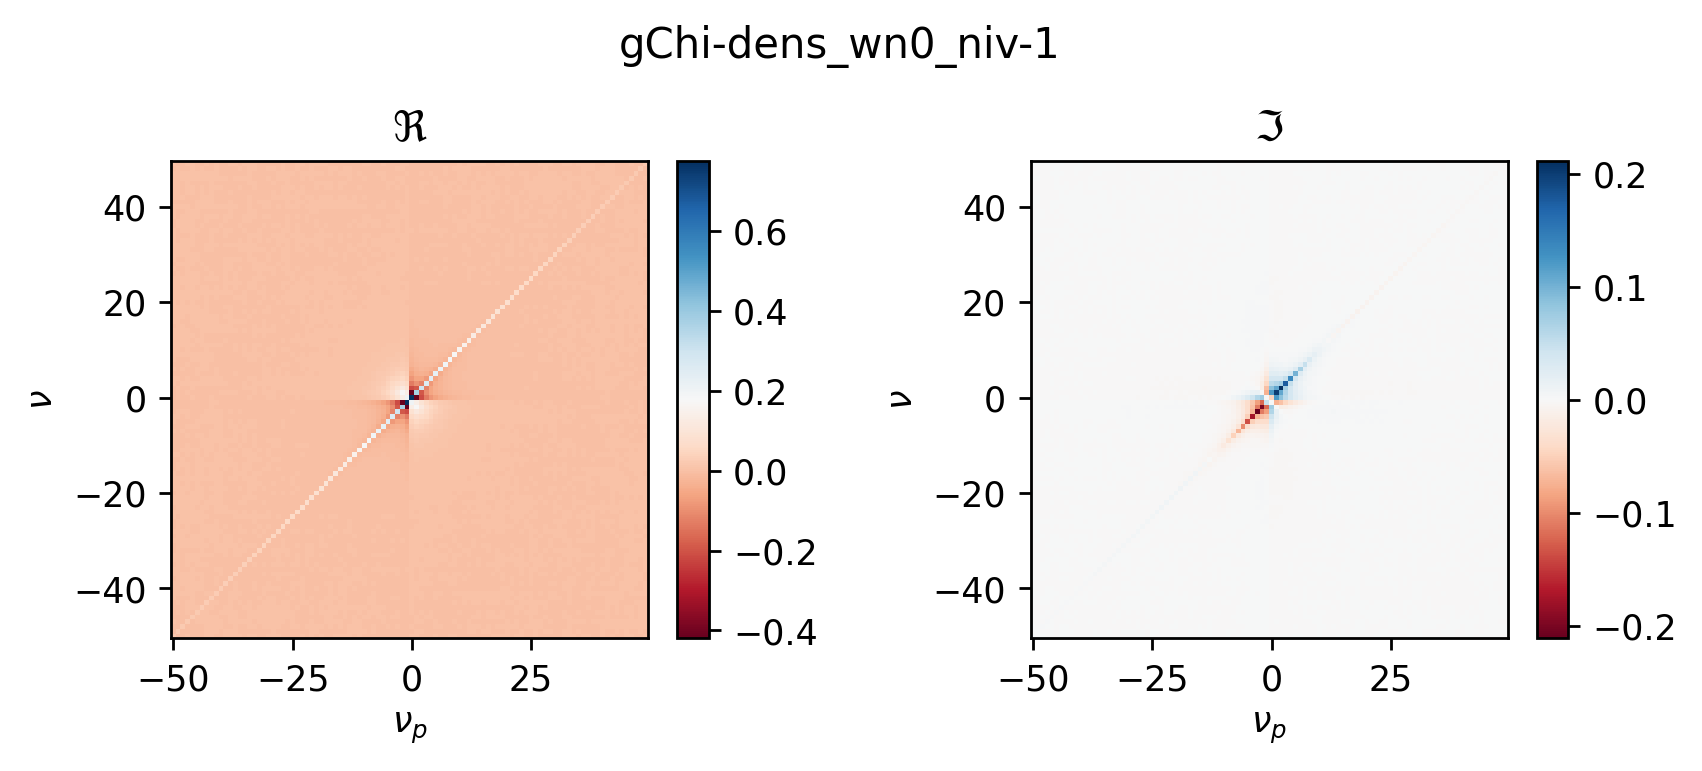

In [4]:
# As a next step we compute the generalized susceptibility:

gchi_dens = lfp.gchir_from_g2(g4iw_dens,giw)
gchi_magn = lfp.gchir_from_g2(g4iw_magn,giw)

gchi_dens.plot(iwn=0,do_save=False,verbose=True,name='gChi-dens')

For the Schwinger-Dyson equation in its Hedin form we need the Green's function the Hedin vertex (also called three-leg
vertex, or fermi-bose vertex) and the (physical) susceptibility.

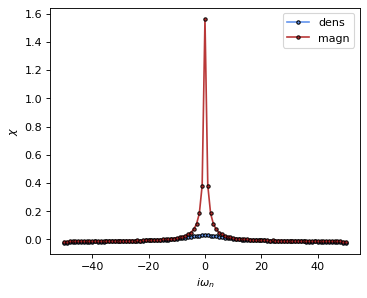

In [5]:
# To get the susceptibility (no lambda correction is needed for the local part):

chi_dens = gchi_dens.contract_legs()
chi_magn = gchi_magn.contract_legs()

plt.figure(figsize=(5,4), dpi=80)
plt.plot(gchi_dens.wn,chi_dens.real,'-o',color='cornflowerblue',markeredgecolor='k',label='dens')
plt.plot(gchi_magn.wn,chi_magn.real,'-o',color='firebrick',markeredgecolor='k',label='magn')
plt.xlabel(r'$i\omega_n$')
plt.ylabel(r'$\chi$')
plt.legend()
plt.show()

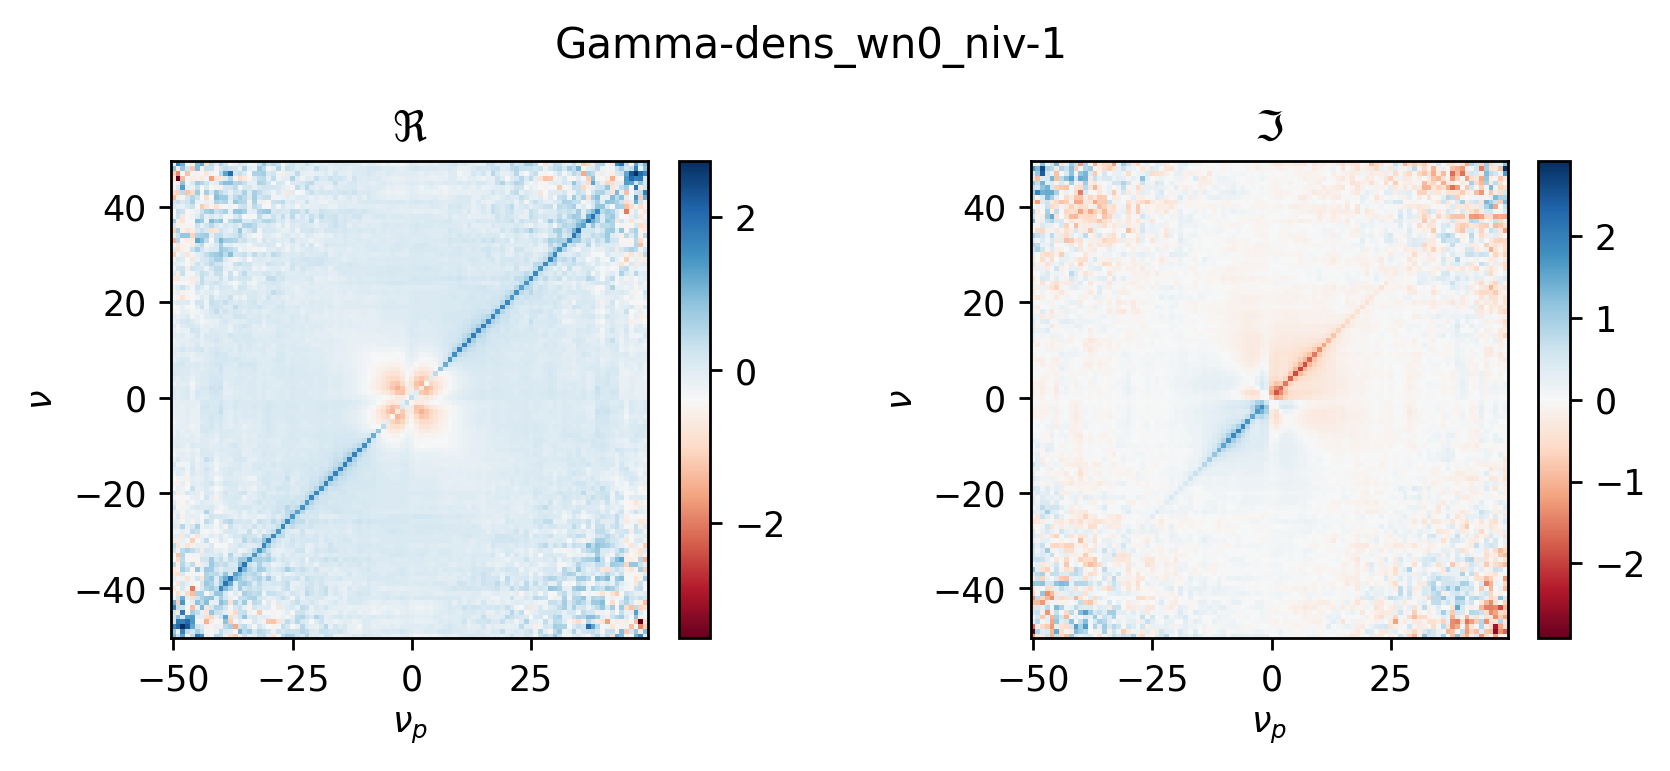

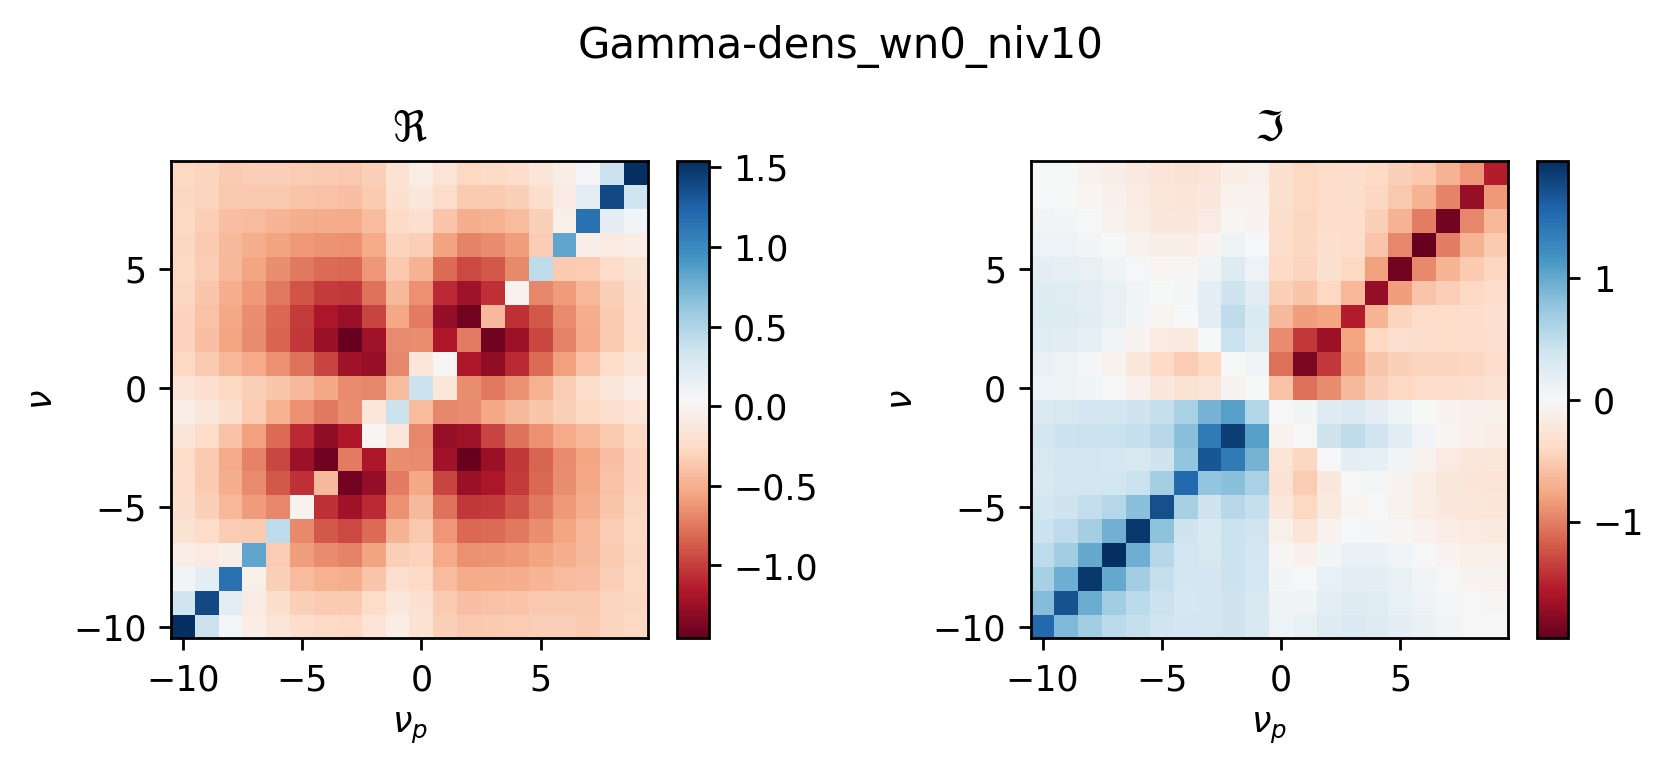

In [6]:
# For the three-leg vertex we also need the bubble:
import dga.bubble as bub

bubble_gen = bub.BubbleGenerator(wn=gchi_dens.wn,giwk_obj=giwk_obj)

gchi0_core = bubble_gen.get_gchi0(gchi_dens.niv)

# For the three-leg vertex we use asymtotics:
niv_core = gchi_dens.niv
niv_urange = 100 # also often called niv_shell
niv_full = niv_core + niv_urange

gchi0_urange = bubble_gen.get_gchi0(niv_full)

# Create the irreducible four-point vertex in the particle-hole channel:
gamma_dens = lfp.gamob2_from_gchir_urange(gchi_dens, gchi0_urange)
gamma_magn = lfp.gamob2_from_gchir_urange(gchi_magn, gchi0_urange)

gamma_dens.plot(iwn=0,do_save=False,verbose=True,name='Gamma-dens')
gamma_dens.plot(iwn=0,niv=10,do_save=False,verbose=True,name='Gamma-dens')

In [7]:
# create the three-leg vertex:

vrg_dens, chi_dens_tilde = lfp.get_vrg_and_chir_tilde_from_gammar_uasympt(gamma_dens, bubble_gen,
                                                                        niv_shell=niv_urange)
vrg_magn, chi_magn_tilde = lfp.get_vrg_and_chir_tilde_from_gammar_uasympt(gamma_magn, bubble_gen,
                                                                        niv_shell=niv_urange)

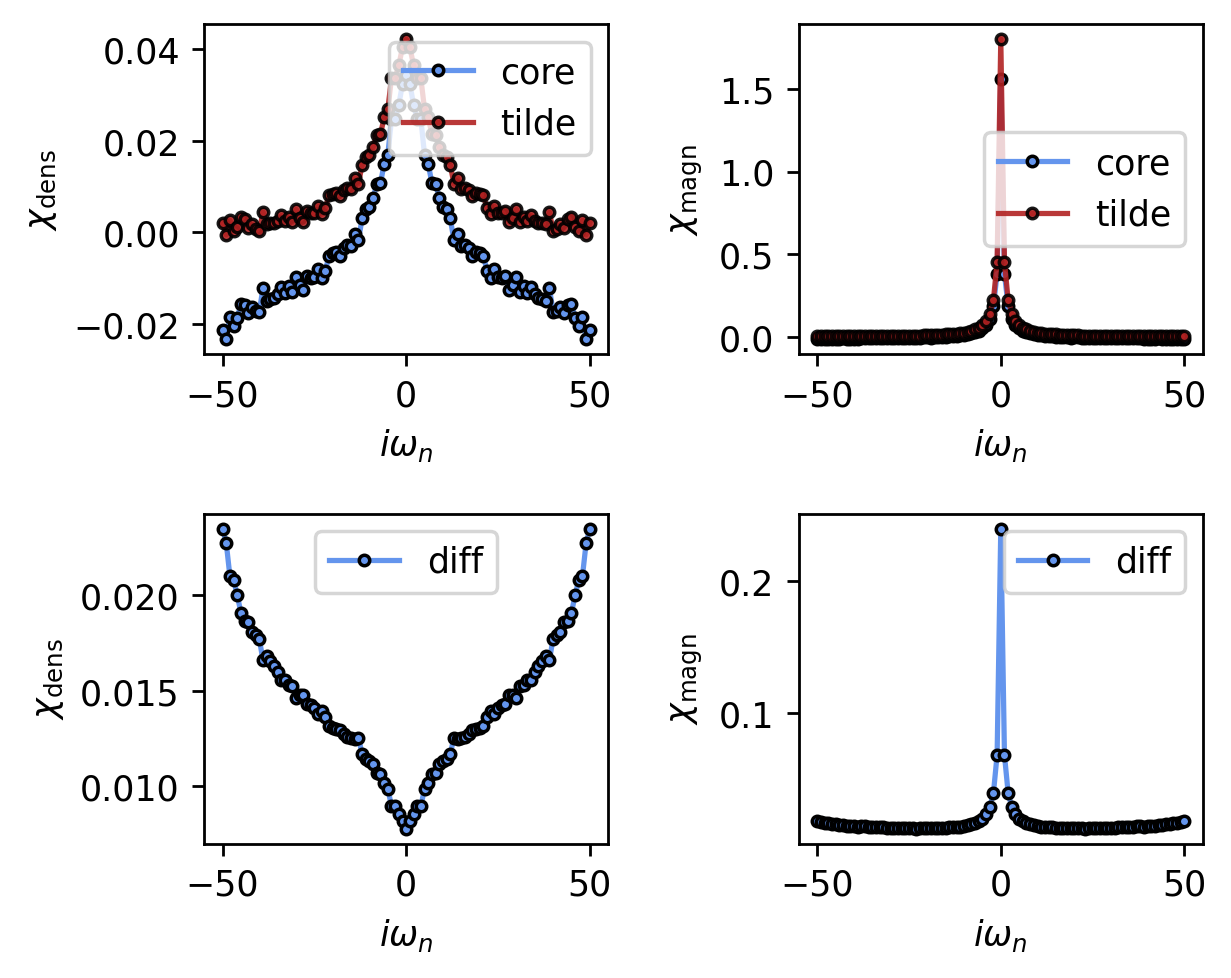

In [8]:

plt.figure(figsize=(5,4), dpi=251)
plt.subplot(2,2,1)
plt.plot(gchi_dens.wn,chi_dens.real,'-o',color='cornflowerblue',markeredgecolor='k',label='core')
plt.plot(gchi_magn.wn,chi_dens_tilde.real,'-o',color='firebrick',markeredgecolor='k',label='tilde')
plt.xlabel(r'$i\omega_n$')
plt.ylabel(r'$\chi_{\rm{dens}}$')
plt.legend()
plt.subplot(2,2,2)
plt.plot(gchi_dens.wn,chi_magn.real,'-o',color='cornflowerblue',markeredgecolor='k',label='core')
plt.plot(gchi_magn.wn,chi_magn_tilde.real,'-o',color='firebrick',markeredgecolor='k',label='tilde')
plt.xlabel(r'$i\omega_n$')
plt.ylabel(r'$\chi_{\rm{magn}}$')
plt.legend()

plt.subplot(2,2,3)
plt.plot(gchi_dens.wn,np.abs(chi_dens.real-chi_dens_tilde),'-o',color='cornflowerblue',markeredgecolor='k',label='diff')
plt.xlabel(r'$i\omega_n$')
plt.ylabel(r'$\chi_{\rm{dens}}$')
plt.legend()

plt.subplot(2,2,4)
plt.plot(gchi_dens.wn,np.abs(chi_magn.real-chi_magn_tilde),'-o',color='cornflowerblue',markeredgecolor='k',label='diff')
plt.xlabel(r'$i\omega_n$')
plt.ylabel(r'$\chi_{\rm{magn}}$')
plt.legend()
plt.tight_layout()
plt.show()

In [9]:
# Now we have all the ingredients to compute the self-energy:

siw_sde = lfp.schwinger_dyson_full(vrg_dens, vrg_magn, chi_dens_tilde, chi_magn_tilde, giwk_obj.g_loc,totdens,
                                   niv_shell=niv_urange)

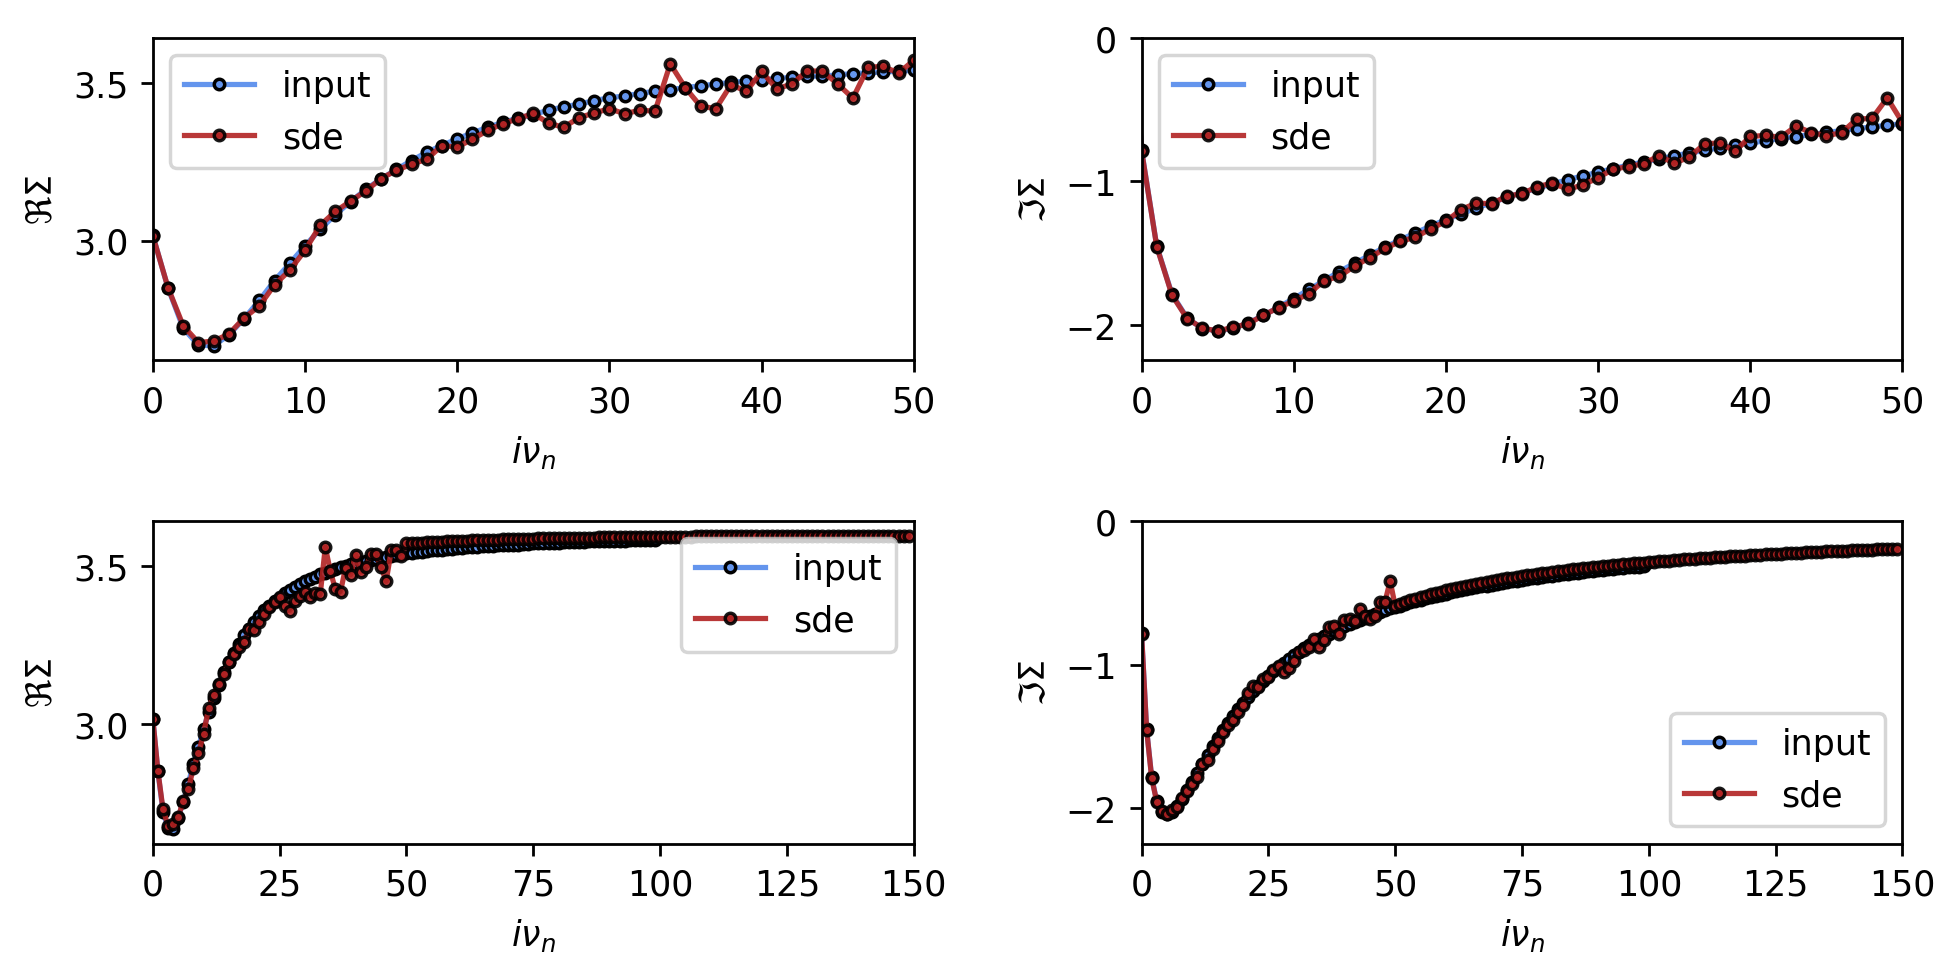

In [10]:
# Plot the self-energy:
import dga.matsubara_frequencies as mf

siw_input = siw_obj.get_siw(niv_urange)[0,0,0,:]

plt.figure(figsize=(8,4), dpi=251)
plt.subplot(2,2,1)
plt.plot(mf.vn(siw_input),siw_input.real,'-o',color='cornflowerblue',markeredgecolor='k',label='input')
plt.plot(mf.vn(siw_sde),siw_sde.real,'-o',color='firebrick',markeredgecolor='k',label='sde')
plt.xlabel(r'$i\nu_n$')
plt.ylabel(r'$\Re \Sigma$')
plt.xlim(0,niv_core)
plt.legend()
plt.subplot(2,2,2)
plt.plot(mf.vn(siw_input),siw_input.imag,'-o',color='cornflowerblue',markeredgecolor='k',label='input')
plt.plot(mf.vn(siw_sde),siw_sde.imag,'-o',color='firebrick',markeredgecolor='k',label='sde')
plt.xlabel(r'$i\nu_n$')
plt.ylabel(r'$\Im \Sigma$')
plt.xlim(0,niv_core)
plt.ylim(None,0)
plt.legend()
plt.subplot(2,2,3)
plt.plot(mf.vn(siw_input),siw_input.real,'-o',color='cornflowerblue',markeredgecolor='k',label='input')
plt.plot(mf.vn(siw_sde),siw_sde.real,'-o',color='firebrick',markeredgecolor='k',label='sde')
plt.xlabel(r'$i\nu_n$')
plt.ylabel(r'$\Re \Sigma$')
plt.xlim(0,niv_full)
plt.legend()
plt.subplot(2,2,4)
plt.plot(mf.vn(siw_input),siw_input.imag,'-o',color='cornflowerblue',markeredgecolor='k',label='input')
plt.plot(mf.vn(siw_sde),siw_sde.imag,'-o',color='firebrick',markeredgecolor='k',label='sde')
plt.xlabel(r'$i\nu_n$')
plt.ylabel(r'$\Im \Sigma$')
plt.xlim(0,niv_full)
plt.ylim(None,0)
plt.legend()
plt.tight_layout()

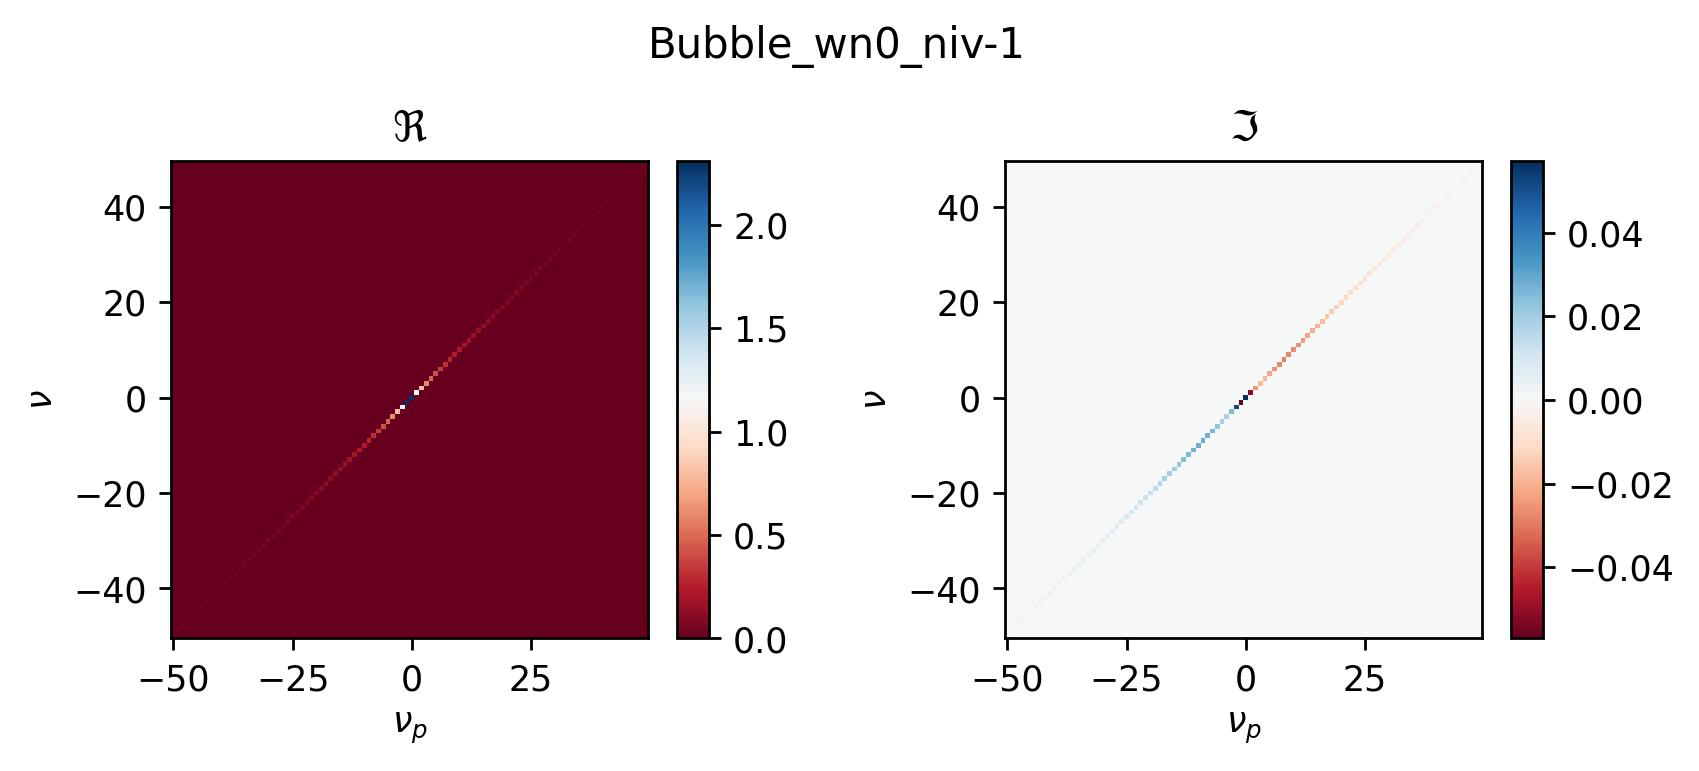

In [11]:
bub_obj = lfp.LocalFourPoint(channel='dens',
                             mat=np.array([np.diag(gchi0_core[i,:]) for i in range(len(gchi0_core))]),beta=beta,u=u,
                             is_full_w=True)
bub_obj.plot(iwn=0,do_save=False,verbose=True,name='Bubble')